# Train a network where a 'BG' node drives a 'cortical (or motor cortical)' node.
    - If the basal ganglia is important for learning, then in some cases, output from downstream areas (i.e., cortex) will be driven by output from the BG.
    - How can we tell when a given behavior is 'bg-driven' or 'cortically-driven'?
    - To test some ideas, I'm training a single rnn node (cortex) to generate 1 of 2 sine waves (different frequencies) when given a condition-specific input and a condition-invariant go cue.
    - I'm then going to freeze all of the weights in this node (input, recurrent, and output weights), and plug in a second node (BG).
    - BG is going to be connected to cortex via a single dense layer (thalamus).
    - I'm then going to train the whole 2-node network to generate 5 sines, 2 of which the cortical node can already generate on its own.
    - What does the activity in these 2 nodes look like during the bg-driven and cortically-driven conditions?
    - Can I tell, just from the activity in these nodes, whether a given condition is driven by cortex or BG?

In [1]:
%matplotlib inline

# import modules

from pylab import *
from scipy import stats
import sklearn

import os
import scipy.io
import keras

from keras.models import Sequential
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import initializers
from keras.models import load_model
from keras import regularizers
from numpy import matlib

from keras import backend as K
import tensorflow as tf

In [2]:
# Prevent TF from accessing the GPU.
tf.config.experimental.set_visible_devices([],'GPU')

In [92]:
# define various paths

# path to trained weights
weightPath = '/Users/andrew/Documents/Projects/Churchland/BG/networks/weights/'

# where to save generated figures
figPath = '/Users/andrew/Documents/Projects/Churchland/BG/networks/figures/'



### General Parameters

In [58]:
# when does the input turn on? 
inputOn_Range = np.array([5, 15])

# how long does the instruction stay on? 
inputDuration_Range = np.array([5,30])

# what is the duration between when the instruction turns off and the first segment begins?
outputDelay = 5

# what is the duration of the output?
outputDuration = 100

# total duration of end buffer (to force model return to baseline )
endBufferDuration = 20

# number if inputs 
numInputs_MC = 2
numInputs_BG = 2

# number of output units
numOutput = 1

# number of recurrent units 
numRecurrent = 100

# number of 'thalamic units' between BG and MC
numThal = 3

# number of training epochs 
numTrainingEpochs = int(1e3)

# theshold for stopping training
stopThreshold = 0.001

# hyperparameters
activity_alpha = 1e-8
recurrentW_alpha = 1e-6
outputW_alpha = 1e-8

# std of noise used during training
noiseScale = 1e-5

### Condition parameters

In [59]:
# output frequencies
# MC is trained on 1 Hz and 2 Hz, BG drives to 3-5 Hz 
numConditions_MC = 2
outputFrequencies_MC = np.arange(numConditions_MC)+1

numConditions_BG = 5
outputFrequencies_BG = np.arange(numConditions_BG)+1
                                       
# define input values
conditionInputs_MC = np.arange(numConditions_MC) + 1
conditionInputs_BG = np.arange(numConditions_BG) + 1

### Define our generators

In [60]:
# this generator is for the initial training of the MC module. It produces an input for the BG module, but its just an array of 0's

def generator_MC(): 
    
    while True: 

        # pick a time for the input to turn on
        inputOnTime = np.random.randint(inputOn_Range[0], inputOn_Range[1])
        
        # when does input turn off?
        inputOffTime = inputOnTime + np.random.randint(inputDuration_Range[0], inputDuration_Range[1])
        
        # when does the output start? 
        outputStartTime = inputOffTime + outputDelay
        
        # what is the total duration of the trial?
        trialDuration = outputStartTime + outputDuration + endBufferDuration
        
        # initialize the inputs and target (time x 1 x C) and (time x 1 x C)
        input_MC = np.zeros([trialDuration, numInputs_MC,numConditions_MC])
        input_BG = np.zeros([trialDuration, numInputs_BG,numConditions_MC])
        target_MC = np.zeros([trialDuration,numOutput,numConditions_MC])
        target_BG = np.zeros([trialDuration,numOutput,numConditions_MC])
        
        # randomize the order of the conditions
        CONDITIONS = np.random.permutation(numConditions_MC)
        
        # cycle through conditions
        for n in arange(numConditions_MC):
                           
            # plug in the appropriate input
            input_MC[inputOnTime:inputOffTime,0,n] = 1
            input_MC[inputOnTime:inputOffTime,1,n] = conditionInputs_MC[CONDITIONS[n]]
        
            # plug in target
            startIdx = outputStartTime
            x = np.arange(outputDuration)*(1/10)
            target_MC[startIdx:(startIdx + outputDuration),0,n] = sin(x*outputFrequencies_MC[CONDITIONS[n]])  
                              
        # add a small amount of noise to the input
        input_MC = input_MC + (np.random.randn(trialDuration,numInputs_MC,numConditions_MC) * np.sqrt(noiseScale))
                   
        # permute input and target to 1 x T x K 
        inputMC_pmt = np.transpose(input_MC,(2,0,1))
        inputBG_pmt = np.transpose(input_BG,(2,0,1))
        targetMC_pmt = np.transpose(target_MC,(2,0,1))
        targetBG_pmt = np.transpose(target_BG,(2,0,1))
        
        # yield input and target
        yield [inputBG_pmt, inputMC_pmt], [targetBG_pmt, targetMC_pmt]

In [61]:
# Generator for training BG module (after MC weights are frozen) 

def generator_BG(): 
    
    while True: 

        # pick a time for the input to turn on
        inputOnTime = np.random.randint(inputOn_Range[0], inputOn_Range[1])
        
        # when does input turn off?
        inputOffTime = inputOnTime + np.random.randint(inputDuration_Range[0], inputDuration_Range[1])
        
        # when does the output start? 
        outputStartTime = inputOffTime + outputDelay
        
        # what is the total duration of the trial?
        trialDuration = outputStartTime + outputDuration + endBufferDuration
        
        # initialize the inputs and target (time x 1 x 1) and (time x 1 x 1)
        input_MC = np.zeros([trialDuration, numInputs_MC,numConditions_BG])
        input_BG = np.zeros([trialDuration, numInputs_BG,numConditions_BG])
        target = np.zeros([trialDuration,numOutput,numConditions_BG])
        
        # randomize the order of the conditions
        CONDITIONS = np.random.permutation(numConditions_BG)
        
        # cycle through conditions
        for n in arange(numConditions_BG):
                           
            # plug in the appropriate input (BG)
            input_BG[inputOnTime:inputOffTime,0,n] = 1
            input_BG[inputOnTime:inputOffTime,1,n] = conditionInputs_BG[CONDITIONS[n]]
            
            # MC input
            input_MC[inputOnTime:inputOffTime,0,n] = 1
            input_MC[inputOnTime:inputOffTime,1,n] = conditionInputs_BG[CONDITIONS[n]]
                    
            # plug in target
            startIdx = outputStartTime
            x = np.arange(outputDuration)*(1/10)
            target[startIdx:(startIdx + outputDuration),0,n] = sin(x*outputFrequencies_BG[CONDITIONS[n]])               
                                             
        # add a small amount of noise to the inputs
        input_MC = input_MC + (np.random.randn(trialDuration,numInputs_MC,numConditions_BG) * np.sqrt(noiseScale))
        input_BG = input_BG + (np.random.randn(trialDuration,numInputs_BG,numConditions_BG) * np.sqrt(noiseScale))
                   
        # permute input and target to 1 x T x K 
        inputMC_pmt = np.transpose(input_MC,(2,0,1))
        inputBG_pmt = np.transpose(input_BG,(2,0,1))
        target_pmt = np.transpose(target,(2,0,1))
        
        # yield input and target
        yield [inputBG_pmt, inputMC_pmt], [target_pmt, target_pmt]

In [62]:
# build the model

# start with an input node to the BG node 
inputs_bg = keras.Input(shape = (None, numInputs_BG),name = 'inputs_bg')

# define bg node
# this layer is not trainable for the initial MC node training
bg = keras.layers.SimpleRNN(numRecurrent, activation='tanh',
           return_sequences = True,
           activity_regularizer = regularizers.l2(activity_alpha),
           recurrent_regularizer = regularizers.l2(recurrentW_alpha),name = 'BG',
                           trainable = False)

# define the output of the bg
bgOutput = bg(inputs_bg)

# define a dense readout unit from BG
bgDenseOutput = keras.layers.Dense(numOutput,kernel_regularizer = regularizers.l2(outputW_alpha))(bgOutput)

# define the thalamic layer
# initialize the thalamic weights (weights from BG -> thal. to 0 and set the biases to 0) 
# these weights are going to be frozen for the initial training of the MC layer
thal = keras.layers.Dense(numThal,kernel_regularizer = regularizers.l2(outputW_alpha),name = 'THAL',
                         kernel_initializer = initializers.Zeros(),
                         bias_initializer   = initializers.Zeros(),
                         trainable = False)(bgOutput)

# define the MC node
# do not use any bias, just to make life a bit easier later
MC = keras.layers.SimpleRNN(numRecurrent, activation='tanh',
           return_sequences = True,
           activity_regularizer = regularizers.l2(activity_alpha),
           recurrent_regularizer = regularizers.l2(recurrentW_alpha),name = 'MC',
           use_bias = False)

# define the non-thalamic input to the MC node
inputs_mc = keras.Input(shape = (None, numInputs_MC),name = 'inputs_mc')

# concatenate output from thalamus and input_mc
MC_input = keras.layers.concatenate([thal, inputs_mc])

# get the output of the MC node
MC_output = MC(MC_input)

# define a dense readout unit 
modelOutput = keras.layers.Dense(numOutput,kernel_regularizer = regularizers.l2(outputW_alpha))(MC_output)

# create the full model
model = keras.Model(inputs=[inputs_bg,inputs_mc], outputs=[bgDenseOutput,modelOutput])

# define the parameters for our optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad=True)

# compile the model
model.compile(loss = 'mean_squared_error',
             optimizer = adam,
             metrics=['accuracy'])


/Users/andrew/miniconda3/envs/BG_modeling_v2/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [63]:
# print a summary of the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs_bg (InputLayer)         [(None, None, 2)]    0           []                               
                                                                                                  
 BG (SimpleRNN)                 (None, None, 100)    10300       ['inputs_bg[0][0]']              
                                                                                                  
 THAL (Dense)                   (None, None, 3)      303         ['BG[0][0]']                     
                                                                                                  
 inputs_mc (InputLayer)         [(None, None, 2)]    0           []                               
                                                                                            

In [64]:
# train the model

# set up saving of the weights of each model (so we can return to the best) 
modelCheckPoint = ModelCheckpoint(weightPath + 'MC_BGDriver_MCweights.hdf5',
                                      monitor = 'loss',verbose = 0, save_best_only=True, save_weights_only = True)

earlyStop = EarlyStopping(monitor = 'loss',min_delta = 0,patience = 500,restore_best_weights = True)

# track out minimum loss
minLoss = inf

# train
while minLoss > stopThreshold:

    # fit
    history = model.fit_generator(generator_MC(), epochs = numTrainingEpochs, steps_per_epoch = 1,
                              callbacks = [modelCheckPoint,earlyStop],verbose=0)

    # load the weights that produced the best accuracy
    model.load_weights(weightPath + 'MC_BGDriver_MCweights.hdf5')

    # check our minimum loss
    minLoss = np.min(history.history['loss'])

/var/folders/h4/g8hnl8017b358kqbslb6bbx40000gn/T/ipykernel_99437/1204899679.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator_MC(), epochs = 1000, steps_per_epoch = 1,


### test trained model 

1/1 [==============================] - 0s 8ms/step


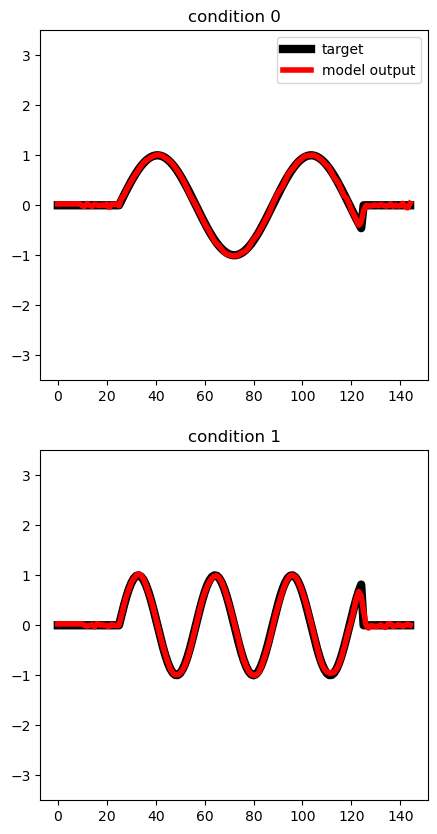

In [69]:
# pick a time for the input to turn on
inputOnTime = 10

# when does input turn off?
inputOffTime = 20

# when does the output start? 
outputStartTime = inputOffTime + outputDelay
# what is the total duration of the trial?
trialDuration = outputStartTime + outputDuration + endBufferDuration

# initialize the inputs and target (time x 1 x C) and (time x 1 x C)
input_MC = np.zeros([trialDuration, numInputs_MC,numConditions_MC])
input_BG = np.zeros([trialDuration, numInputs_BG,numConditions_MC])
target_MC = np.zeros([trialDuration,numOutput,numConditions_MC])
target_BG = np.zeros([trialDuration,numOutput,numConditions_MC])

# randomize the order of the conditions
CONDITIONS = np.random.permutation(numConditions_MC)

# cycle through conditions
for n in arange(numConditions_MC):

    # plug in the appropriate input
    input_MC[inputOnTime:inputOffTime,0,n] = 1
    input_MC[inputOnTime:inputOffTime,1,n] = conditionInputs_MC[CONDITIONS[n]]

    # plug in target
    startIdx = outputStartTime
    x = np.arange(outputDuration)*(1/10)
    target_MC[startIdx:(startIdx + outputDuration),0,n] = sin(x*outputFrequencies_MC[CONDITIONS[n]])  

# permute input and target to 1 x T x K 
inputMC_pmt = np.transpose(input_MC,(2,0,1))
inputBG_pmt = np.transpose(input_BG,(2,0,1))
targetMC_pmt = np.transpose(target_MC,(2,0,1))
targetBG_pmt = np.transpose(target_BG,(2,0,1))
        
# redefine our model inputs (will be useful later on)
inputMC_model1_pmt = np.copy(inputMC_pmt)
inputBG_model1_pmt = np.copy(inputBG_pmt)

# get model output
modelOutput_MC = model.predict([inputBG_pmt,inputMC_pmt])[1]

# plot model performance
plt.figure(figsize=(5,10))
for i in arange(numConditions_MC):
    plt.subplot(numConditions_MC,1,i+1)
    plt.plot(target_MC[:,0,i],color = 'k',linewidth=6,label='target');
    plt.plot(modelOutput_MC[i,:,0], color = 'r',linewidth = 4,label='model output');
    plt.ylim([-3.5, 3.5]);
    plt.title('condition ' + str(i))

    if i ==0:
        plt.legend();


In [70]:
# define a constraint that freezes the recurrent weights during training

from keras.constraints import Constraint

class FreezeSlice(Constraint):
    """
    Constraint which keeps a certain slice frozen at chosen values

    INPUTS:

    values - An object which can be converted into a numpy ndarray. These are
             the pre-chosen values. When using this constraint, the user should
             ensure that the dtype of values can be converted to the desired
             dtype of the weight tensor.

    """
    def __init__(self, values):
        if hasattr(values, "numpy"):
            self.values = values.numpy()
        elif isinstance(values, np.ndarray):
            self.values = values
        else:
            try:
                self.values = values.to_numpy()
            except:
                self.values = np.array(values)

        self.values = values

    def __call__(self, w):
        zs = np.zeros(w.shape)
        zs = self.values
        os = np.ones(w.shape)
        os = 0
        return w * os + zs
    

In [71]:
# define a similar constraint that freezes a slice of weights
from keras.constraints import Constraint

class FreezeSlice_input(Constraint):
    """
    Constraint which keeps a certain slice frozen at chosen values

    INPUTS:

    values - An object which can be converted into a numpy ndarray. These are
             the pre-chosen values. When using this constraint, the user should
             ensure that the dtype of values can be converted to the desired
             dtype of the weight tensor.

    slice - A slice or tuple of slices (it is recommended to use numpy.s_ to
            specify this parameter). This specifies which entries should be
            filled with the pre-chosen values. When using this initializer,
            the user should ensure that the slice object "fits inside" the shape
            of the tensor to be initialized, and that the resulting slice of the
            tensor has the same shape as the values ndarray.
    """
    def __init__(self, values, slice):
        if hasattr(values, "numpy"):
            self.values = values.numpy()
        elif isinstance(values, np.ndarray):
            self.values = values
        else:
            try:
                self.values = values.to_numpy()
            except:
                self.values = np.array(values)

        self.values = values
        self.slice = slice

    def __call__(self, w):
        zs = np.zeros(w.shape)
        zs[self.slice] = self.values
        os = np.ones(w.shape)
        os[self.slice] = 0
        return w * os + zs

In [72]:
# pull out the trained weights of the MC node
MC_W = model.layers[5].get_weights()[1]
MC_inW = model.layers[5].get_weights()[0][3:,:]

#### Because the cortical node can already generate the first 2 conditions, it would be a totally reasonable strategy for the BG node to just be silent during these conditions.
    - To prevent this, I'm also requiring the BG node to generate the same output that MC needs to generate.

In [73]:
# now build a new model, substituting adding in the additional constraint for the MC node 

# start with an input node to the BG node 
inputs_bg = keras.Input(shape = (None, numInputs_BG),name = 'inputs_bg')

# define bg node
# this layer is not trainable for the initial MC node training
bg = keras.layers.SimpleRNN(numRecurrent, activation='tanh',
           return_sequences = True,
           activity_regularizer = regularizers.l2(activity_alpha),
           recurrent_regularizer = regularizers.l2(recurrentW_alpha),name = 'BG',
                           trainable = True)

# define the output of the bg
bgOutput = bg(inputs_bg)

# define a dense readout unit from BG
bgDenseOutput = keras.layers.Dense(numOutput,kernel_regularizer = regularizers.l2(outputW_alpha))(bgOutput)

# define the thalamic layer
thal = keras.layers.Dense(numThal,kernel_regularizer = regularizers.l2(outputW_alpha),name = 'THAL',
                         kernel_initializer = initializers.Zeros(),
                         bias_initializer   = initializers.Zeros(),
                         trainable = True)(bgOutput)

# define the MC node using our new constraints on the input and recurrent weights
MC = keras.layers.SimpleRNN(numRecurrent, activation='tanh',
           return_sequences = True,
           activity_regularizer = regularizers.l2(activity_alpha),
           recurrent_regularizer = regularizers.l2(recurrentW_alpha),name = 'MC',
           use_bias = False,
           recurrent_constraint = FreezeSlice(MC_W),
           kernel_constraint = FreezeSlice_input(MC_inW,np.s_[3:,:]))

# define the non-thalamic input to the MC node
inputs_mc = keras.Input(shape = (None, numInputs_MC),name = 'inputs_mc')

# concatenate output from thalamus and input_mc
MC_input = keras.layers.concatenate([thal, inputs_mc])

# get the output of the MC node
MC_output = MC(MC_input)

# define a dense readout unit 
# note that these weights are frozen 
modelOutput = keras.layers.Dense(numOutput,kernel_regularizer = regularizers.l2(outputW_alpha),
                                trainable = False)(MC_output)

# create the full model
model2 = keras.Model(inputs=[inputs_bg,inputs_mc], outputs=[bgDenseOutput,modelOutput])

In [74]:
# compile the model
model2.compile(loss = 'mean_squared_error',
             optimizer = adam,
             metrics=['accuracy'])

In [75]:
# load the weights of the previously trained model
model2.load_weights(weightPath + 'MC_BGDriver_MCweights.hdf5')

In [80]:
# train the model

# set up saving of the weights of each model (so we can return to the best)
modelCheckPoint = ModelCheckpoint(weightPath + 'MC_BGDriver_BGweights.hdf5',
                                      monitor = 'loss',verbose = 0, save_best_only=True, save_weights_only = True)

earlyStop = EarlyStopping(monitor = 'loss',min_delta = 0,patience = 500,restore_best_weights = True)

# track out minimum loss
minLoss = inf

# train
while minLoss > stopThreshold:

    # fit
    history = model2.fit_generator(generator_BG(), epochs = numTrainingEpochs, steps_per_epoch = 1,
                              callbacks = [modelCheckPoint,earlyStop],verbose=0)

    # load the weights that produced the best accuracy
    model2.load_weights(weightPath + 'MC_BGDriver_BGweights.hdf5')

    # check our minimum loss
    minLoss = np.min(history.history['loss'])

/var/folders/h4/g8hnl8017b358kqbslb6bbx40000gn/T/ipykernel_99437/1068488666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(generator_BG(), epochs = numTrainingEpochs, steps_per_epoch = 1,


### test trained model

1/1 [==============================] - 0s 8ms/step


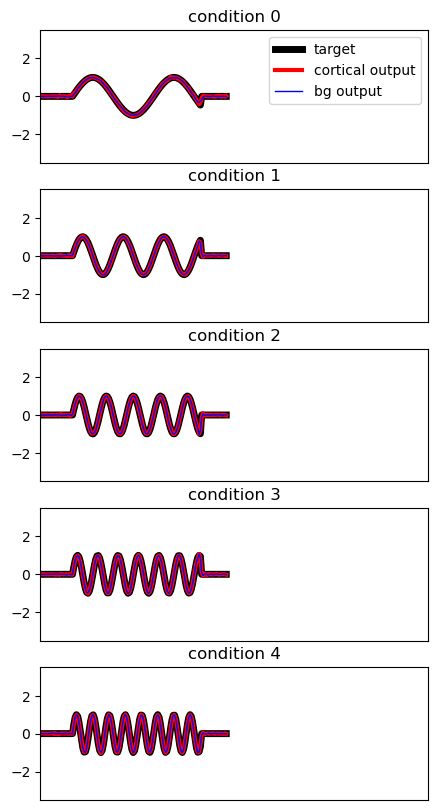

In [157]:
# pick a time for the input to turn on
inputOnTime = 10

# when does input turn off?
inputOffTime = 20

# when does the output start? 
outputStartTime = inputOffTime + outputDelay

# what is the total duration of the trial?
trialDuration = outputStartTime + outputDuration + endBufferDuration

# initialize the inputs and target (time x 1 x 1) and (time x 1 x 1)
input_MC = np.zeros([trialDuration, numInputs_MC,numConditions_BG])
input_BG = np.zeros([trialDuration, numInputs_BG,numConditions_BG])
target = np.zeros([trialDuration,numOutput,numConditions_BG])

# randomize the order of the conditions
CONDITIONS = np.arange(numConditions_BG)

# cycle through conditions
for n in arange(numConditions_BG):

    # plug in the appropriate input (BG)
    input_BG[inputOnTime:inputOffTime,0,n] = 1
    input_BG[inputOnTime:inputOffTime,1,n] = conditionInputs_BG[CONDITIONS[n]]

    # MC input
    input_MC[inputOnTime:inputOffTime,0,n] = 1
    input_MC[inputOnTime:inputOffTime,1,n] = conditionInputs_BG[CONDITIONS[n]]

    # plug in target
    startIdx = outputStartTime
    x = np.arange(outputDuration)*(1/10)
    target[startIdx:(startIdx + outputDuration),0,n] = sin(x*outputFrequencies_BG[CONDITIONS[n]])               


# permute input and target to 1 x T x K 
inputMC_pmt = np.transpose(input_MC,(2,0,1))
inputBG_pmt = np.transpose(input_BG,(2,0,1))
target_pmt = np.transpose(target,(2,0,1))

# redefine our model inputs (will be useful later on)
inputMC_model2_pmt = np.copy(inputMC_pmt)
inputBG_model2_pmt = np.copy(inputBG_pmt)

# get model output
modelOutput_BG = model2.predict([inputBG_pmt,inputMC_pmt])[0]
modelOutput_MC = model2.predict([inputBG_pmt,inputMC_pmt])[1]

# plot model performance
plt.figure(figsize=(5,10))
for i in arange(numConditions_BG):
    plt.subplot(numConditions_BG,1,i+1)
    plt.plot(target[:,0,i],color = 'k',linewidth=5,label='target');
    plt.plot(modelOutput_MC[i,:,0], color = 'r',linewidth = 3,label='cortical output');
    plt.plot(modelOutput_BG[i,:,0], color = 'b',linewidth = 1,label='bg output');
    plt.ylim([-3.5, 3.5]);
    plt.title('condition ' + str(i))
    plt.tick_params('x',labelbottom=False,bottom=False);
    if i==0:
        plt.legend()
    plt.xlim([0,300]);
    
# save figure
plt.savefig(figPath + 'trainedModelOutput.pdf');

### pull out model rates 
- rates will be a T x N x C tensor

In [132]:
# define a function that gives returns the rates of all of the layers given a input
layers = np.array(model.layers)
inp = [model.layers[0].input, model.layers[3].input]
outputs = [layer.output for layer in layers[np.array([1,2,5])]]   
functors = [K.function(inp,[out]) for out in outputs]

# get outputs for all layers for model 1
rates = [func([inputBG_model1_pmt, inputMC_model1_pmt]) for func in functors]

# pull out the rates from BG layer
rates_bg_1 = np.squeeze(rates[0][0].transpose((1,2,0)))

# rates from thalamus
rates_thal_1 = np.squeeze(rates[1][0].transpose((1,2,0)))

# rates from cortex
rates_ctx_1 = np.squeeze(rates[2][0].transpose((1,2,0)))


 - get rates from model 2 (MC weights are frozen)
 - the first 2 condition matches the output of conditions 0 and 1 from model 1

In [133]:
layers = np.array(model2.layers)
inp = [model2.layers[0].input, model2.layers[3].input]
outputs = [layer.output for layer in layers[np.array([1,2,5])]]
functors = [K.function(inp,[out]) for out in outputs]

# get outputs for all layers for model 2
rates = [func([inputBG_model2_pmt, inputMC_model2_pmt]) for func in functors]

# pull out the rates from BG layer
rates_bg_2 = np.squeeze(rates[0][0].transpose((1,2,0)))

# rates from thalamus
rates_thal_2 = np.squeeze(rates[1][0].transpose((1,2,0)))

# rates from cortex
rates_ctx_2 = np.squeeze(rates[2][0].transpose((1,2,0)))

### Pull out the weights from both models 

In [134]:
## Model 1 ##
# MC 
w_ctx_1 = model.layers[5].get_weights()[1]

# thal -> ctx weights
w_thalCtx_1 = model.layers[5].get_weights()[0][0:3,:]
w_inCtx_1 = model.layers[5].get_weights()[0][3:,:]

# bg weights
w_bg_1 = model.layers[1].get_weights()[1]

# output weights
w_out_1 = model.layers[7].get_weights()[0]

## Model 2 ##
# MC 
w_ctx_2 = model2.layers[5].get_weights()[1]

# thal -> ctx weights
w_thalCtx_2 = model2.layers[5].get_weights()[0][0:3,:]
w_inCtx_2 = model2.layers[5].get_weights()[0][3:,:]

# bg weights
w_bg_2 = model2.layers[1].get_weights()[1]

# output weights
w_out_2 = model2.layers[7].get_weights()[0]

#### verify that the recurrent weights of ctx didn't change between models 1 and 2

In [135]:
# calculate norm of the difference between the J matrices for the cortical node in model 1 and 2
ctxNorm = np.linalg.norm(w_ctx_1 - w_ctx_2, ord='fro')

# do the same for the input and output weights
inputNorm = np.linalg.norm(w_inCtx_1 - w_inCtx_2, ord='fro')

# and the output weights
outputNorm = np.linalg.norm(w_out_1 - w_out_2)

# display results
display('norm of the change in cortex J weights: ' + str(ctxNorm))
display('norm of the change in input weights: ' + str(inputNorm))
display('norm of the change in output weights: ' + str(outputNorm))


'norm of the change in cortex J weights: 0.0'

'norm of the change in input weights: 0.0'

'norm of the change in output weights: 0.0'

### plotting parameters

In [136]:
# plotting colors for Ctx (hot colors) (red for model 1, oranges for model 2)
ctx_color1 = np.array(['lightcoral','darkred'])
ctx_color2 = np.array(['lightcoral','darkred','darkorange','sandybrown','peru'])

# colors for BG (purple)
bg_color2  = np.array(['lightsteelblue','dodgerblue','blueviolet','rebeccapurple','purple'])

# colors for thalamus (green)
thal_color2= np.array(['darkgreen','forestgreen','mediumseagreen','springgreen','olive'])

# line width for single neurons
singleNeuron_lw = 1.65;

# line width for projections
proj_lw = 2.5;


### Plot a few example units from each area
 - plot first 3 neurons in each area

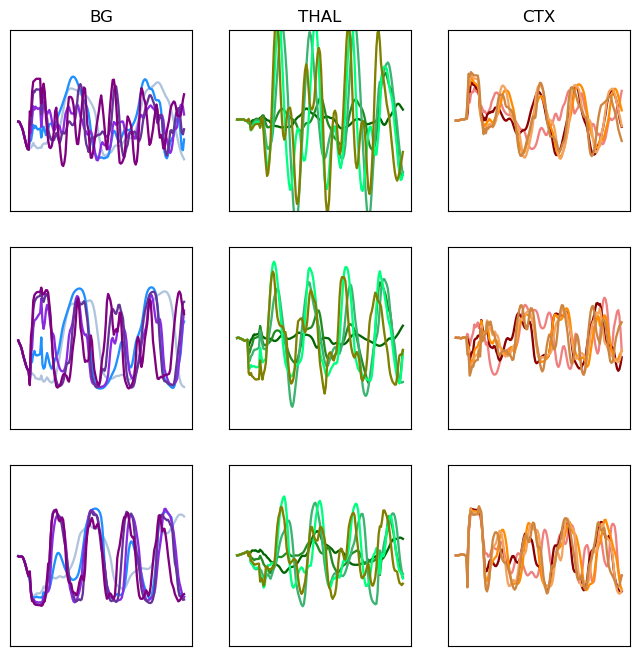

In [137]:
# first column is BG, second is thalamus, third is cortex 
plt.figure(figsize = (8,8));

# title labels
areaLabels = np.array(['BG','THAL','CTX'])

# cycle through areas
for area in np.arange(3):
    
    # get the appropriate colors
    if area == 0:
        colors = bg_color2
        rates = rates_bg_2
    elif area == 1:
        colors = thal_color2
        rates = rates_thal_2
    else:
        colors = ctx_color2
        rates = rates_ctx_2
    
    # cycle through neurons
    for neuron in np.arange(3):
        
        # define the appropriate subplot
        plt.subplot(3,3,(area)+(neuron*3)+1)
        
        # cycle through condititions (handling the 1 condition from model 1 separately)
        for condition in np.arange(5):
            plt.plot(rates[:,neuron,condition],linewidth = singleNeuron_lw,color = colors[condition])

        # remove y axis ticks and tick labels 
        plt.tick_params('both',labelbottom=False,labelleft=False,length = 0);plt.ylim([-1.75,1.75]);
        
        # add a title
        if neuron == 0:
            plt.title(areaLabels[area]);

# save figure
plt.savefig(figPath + 'exampleNeurons.pdf');

### Compare cortical activity in the 2 models
- compare the activity on condition 0

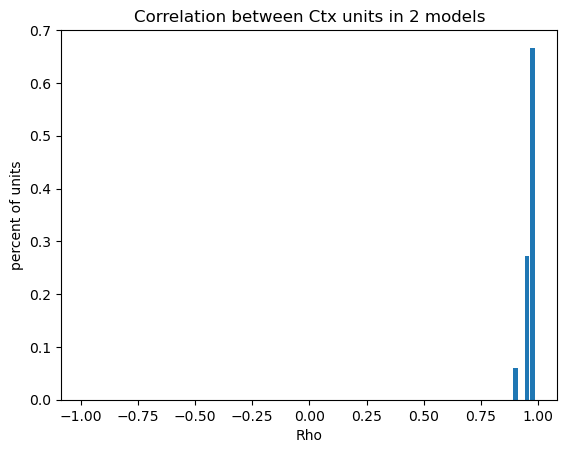

In [168]:
# calculate correlation between the 1 condition in model 1 and the first condition in model 2
# for the cortical data
ctxCorr = np.corrcoef(rates_ctx_1[:,:,0].T,rates_ctx_2[:,:,0].T).diagonal(-100)

# make histogram of correlation values
histBins = np.arange(-1,1,0.025)
corrHist,bins = np.histogram(ctxCorr,bins = histBins)

# normalize count
corrHist = corrHist / np.sum(corrHist)

# plot histogram
plt.figure();
plt.bar(bins[1:],corrHist,width = 0.02);

# add title and labels
plt.title('Correlation between Ctx units in 2 models');
plt.xlabel('Rho');
plt.ylabel('percent of units');

# save figure
plt.savefig(figPath + 'corticalNeuronCorrelations.pdf');


#### For a given neuron, its activity during condition 0 in model 1 is highly similar to its activity during condition 0 in model 2.
    - since we know that thalamus is active during these conditions, thalamic input must be in the null space of cortical activity (not just cortical dynamics).

### Run PCA on the MC activity from model 2
-only use data from the output period (where neither model received any external input)

In [139]:
# import pca
from sklearn.decomposition import PCA

# reshape rates to be CT x N
ratesForPCA_MC2 = rates_ctx_2[30:120,:,:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')

# fit  pca model
pca = PCA(n_components = numRecurrent)
pca.fit(ratesForPCA_MC2);
proj_MC2 = pca.transform(ratesForPCA_MC2)

# project in data from the first model too
ratesForPCA_MC1 = rates_ctx_1[30:120,:,:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')
proj_MC1 = pca.transform(ratesForPCA_MC1)

# reshape projections to be T x C x K 
proj_MC2 = proj_MC2.reshape((-1,numConditions_BG,numRecurrent),order = 'F')
proj_MC1 = proj_MC1.reshape((-1,numConditions_MC,numRecurrent),order = 'F')

#### plot activity in top 2 PCs

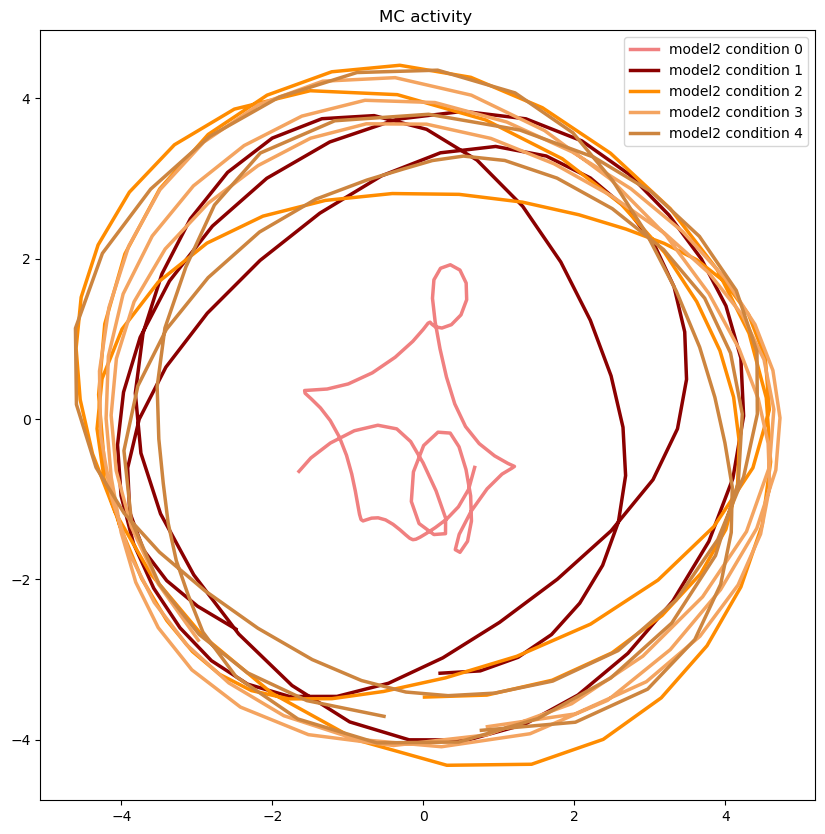

In [170]:
# set up figure
fig = plt.figure(figsize = (10,10))
plt.title('MC activity ')

# plot projection from model 1
for i in np.arange(5):
    plt.plot(proj_MC2[:,i,0],proj_MC2[:,i,1],
             linewidth=proj_lw, color = ctx_color2[i], label= 'model2 condition ' + str(i)  )

# add a legend
plt.legend();

# save figure
plt.savefig(figPath + 'cortex_PC1_vs_PC2.pdf');

#### from this view, it looks like condition 0 is in its own space, and conditions 1-4 are in a different one.
    - This is surprising, since conditions 0 and 1 are both cortically driven

### Run PCA on the BG activity from model 2

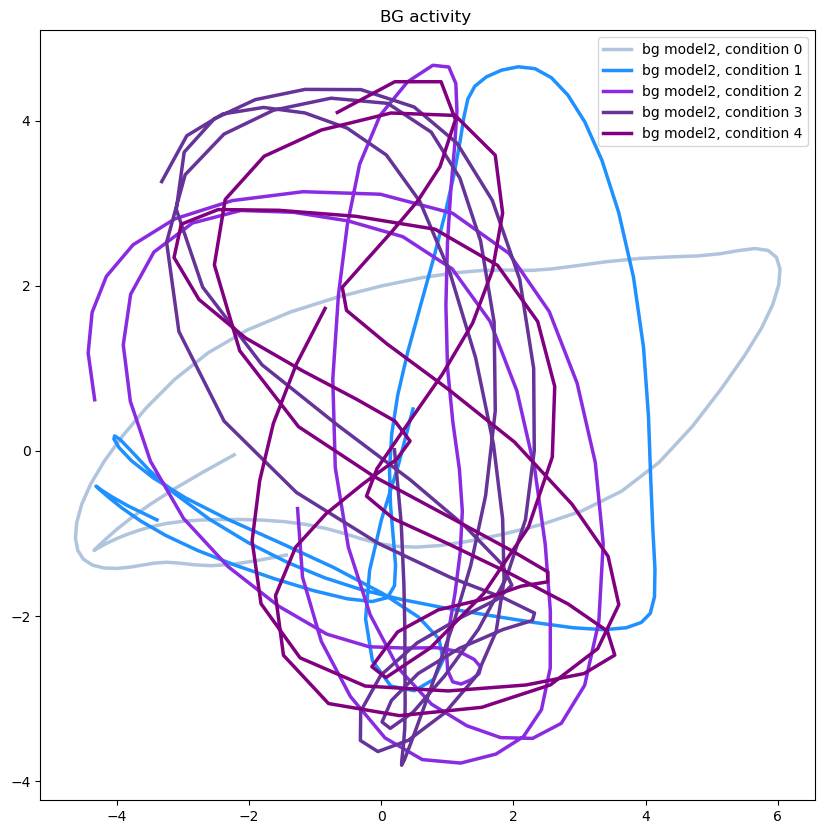

In [171]:
# reshape rates to be CT x N
ratesForPCA_BG2 = rates_bg_2[30:120,:,:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')

# fit  pca model
pca = PCA(n_components = numRecurrent)
pca.fit(ratesForPCA_BG2);
proj_BG2 = pca.transform(ratesForPCA_BG2)

# reshape projections to be T x C x K 
proj_BG2 = proj_BG2.reshape((-1,numConditions_BG,numRecurrent),order = 'F')

# set up figure
fig = plt.figure(figsize = (10,10))
plt.title('BG activity ')

# plot projections from model 2
for i in np.arange(0,5):
    plt.plot(proj_BG2[:,i,0],proj_BG2[:,i,1],
            linewidth = proj_lw,color = bg_color2[i], label='bg model2, condition ' + str(i));

# add a legend
plt.legend();

# save figure
plt.savefig(figPath + 'bg_PC1_vs_PC2.pdf');

### Run PCA on the Thalamic activity from model 2

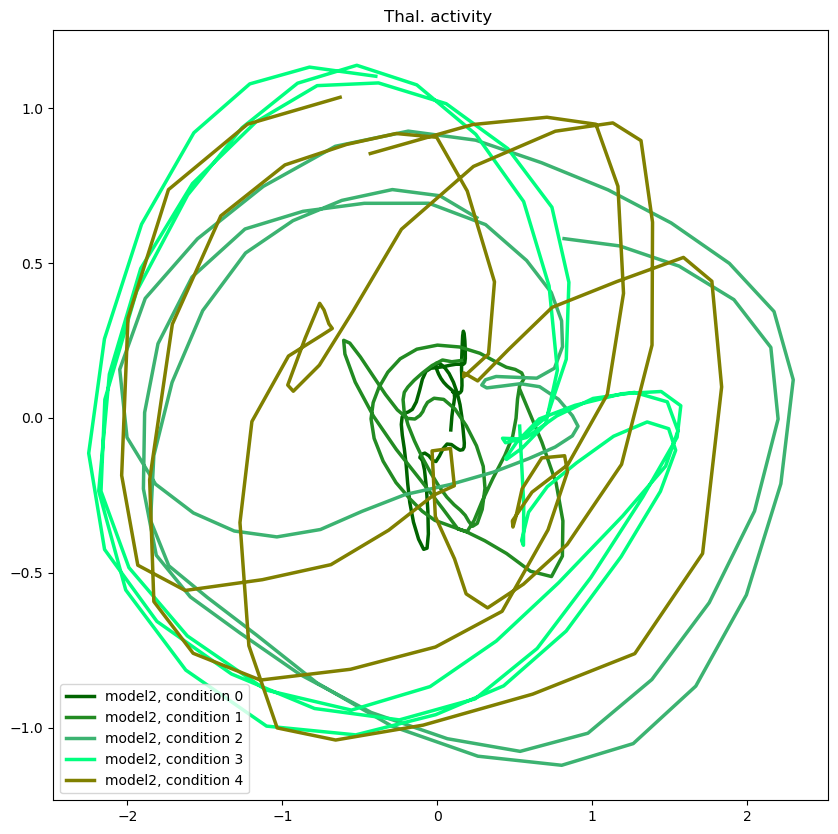

In [172]:
# reshape rates to be CT x N
ratesForPCA_TH2 = rates_thal_2[30:120,:,:].transpose((0,2,1)).reshape((-1,numThal),order = 'F')

# fit  pca model
pca = PCA(n_components = numThal)
pca.fit(ratesForPCA_TH2);
proj_TH2 = pca.transform(ratesForPCA_TH2)

thal_pcaW = pca.components_

# reshape projections to be T x C x K 
proj_TH2 = proj_TH2.reshape((-1,numConditions_BG,numThal),order = 'F')

# set up figure
fig = plt.figure(figsize = (10,10))
plt.title('Thal. activity ')

# plot projections from model 2
for i in np.arange(numConditions_BG):
    plt.plot(proj_TH2[:,i,0],proj_TH2[:,i,1],
            linewidth = proj_lw,color = thal_color2[i], label = 'model2, condition ' + str(i));
plt.legend();

# save figure
plt.savefig(figPath + 'thal_PC1_vs_PC2.pdf');

### Are the spaces occupied (by cortical activity) the same during cortically-driven and bg-driven conditions?
    - run PCA on activity from the cortically-driven conditions, project in all conditions

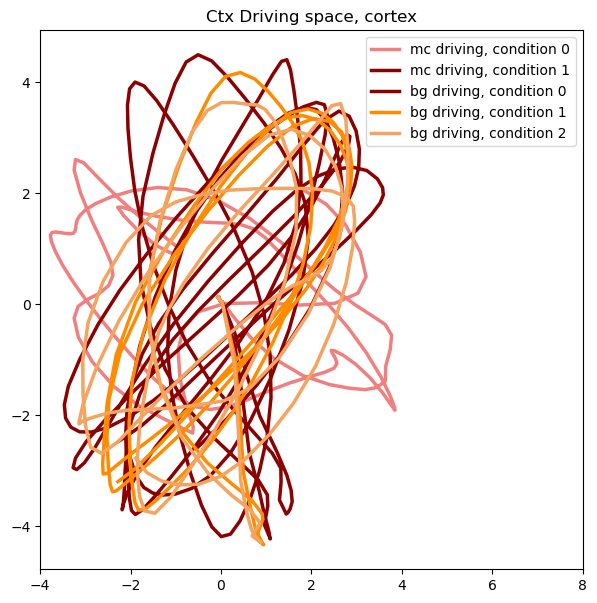

In [179]:
# reshape rates to be CT x N
ratesForPCA_ctxDriving = rates_ctx_2[:,:,:2].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')

# fit  pca model
pca = PCA(n_components = 10)
pca.fit(ratesForPCA_ctxDriving);
proj_ctxDriving = pca.transform(ratesForPCA_ctxDriving).reshape((-1,numConditions_MC,10),order = 'F')

# project in data from the BG-driving conditions too
ratesForPCA_BGdriving = rates_ctx_2[:,:,2:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')
proj_bgDriving = pca.transform(ratesForPCA_BGdriving).reshape((-1,3,10),order = 'F')

# plot first activity in first 3 dimensions

# set up figure
fig = plt.figure(figsize = (7,7))
plt.title('Ctx Driving space, cortex')

# plot projections from ctx driving condition
for i in np.arange(2):
    plt.plot(proj_ctxDriving[:,i,0],proj_ctxDriving[:,i,1],
            linewidth = proj_lw,color = ctx_color1[i], label='mc driving, condition ' + str(i));
    
# plot projection from bg driving condition
for i in np.arange(3):
    plt.plot(proj_bgDriving[:,i,0],proj_bgDriving[:,i,1],
            linewidth = proj_lw,color = ctx_color2[i+1], label='bg driving, condition ' + str(i));

plt.legend();

plt.xlim([-4,8]);

# save figure
plt.savefig(figPath + 'cortexDrivingSpace_ctx.pdf');

#### Now do the reverse: train PCA on BG driving condition and project in Ctx driving condition

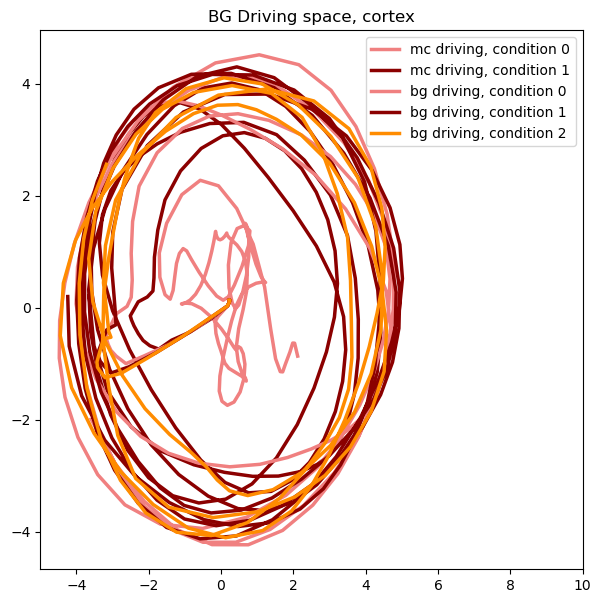

In [180]:
# reshape rates to be CT x N
ratesForPCA_ctxDriving = rates_ctx_2[:,:,:2].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')
ratesForPCA_BGdriving = rates_ctx_2[:,:,2:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')

# fit  pca model
pca = PCA(n_components = 10)
pca.fit(ratesForPCA_BGdriving);
proj_bgDriving = pca.transform(ratesForPCA_BGdriving).reshape((-1,3,10),order = 'F')
proj_ctxDriving = pca.transform(ratesForPCA_ctxDriving).reshape((-1,numConditions_MC,10),order = 'F')

# set up figure
fig = plt.figure(figsize = (7,7))
plt.title('BG Driving space, cortex')

# plot projections from ctx driving condition
for i in np.arange(2):
    plt.plot(proj_ctxDriving[:,i,0].flatten(),proj_ctxDriving[:,i,1].flatten(),
            linewidth = proj_lw,color = ctx_color1[i], label='mc driving, condition ' + str(i));

# plot projection from bg driving condition
for i in np.arange(3):
    plt.plot(proj_bgDriving[:,i,0].flatten(),proj_bgDriving[:,i,1].flatten(),
            linewidth = proj_lw,color = ctx_color2[i],  label='bg driving, condition ' + str(i));

plt.legend();

# save figure
plt.xlim([-5,10]);
plt.savefig(figPath + 'bgDrivingSpace_ctx.pdf');

### Now do the same analysis for BG activity.

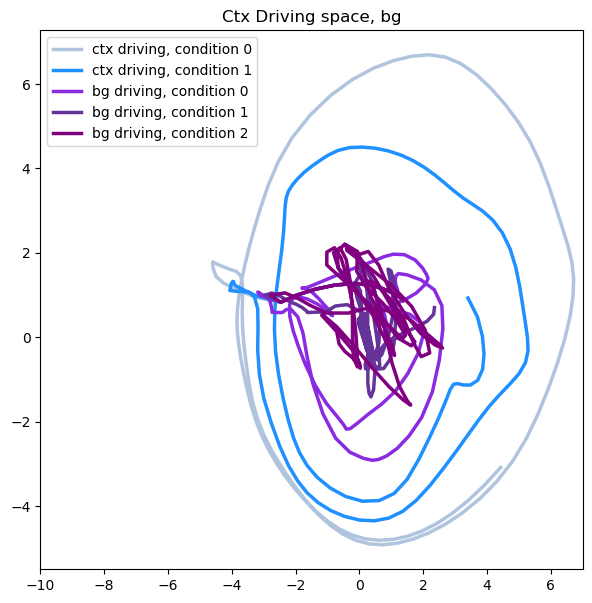

In [182]:
# reshape rates to be CT x N
ratesForPCA_ctxDriving = rates_bg_2[:120,:,:2].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')

# fit  pca model
pca = PCA(n_components = 10)
pca.fit(ratesForPCA_ctxDriving);
proj_ctxDriving = pca.transform(ratesForPCA_ctxDriving).reshape((-1,numConditions_MC,10),order = 'F')

# project in data from the BG-driving conditions too
ratesForPCA_BGdriving = rates_bg_2[:120,:,2:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')
proj_bgDriving = pca.transform(ratesForPCA_BGdriving).reshape((-1,3,10),order = 'F')

# set up figure
fig = plt.figure(figsize = (7,7))
plt.title('Ctx Driving space, bg')

# plot projections from ctx driving condition
for i in np.arange(2):
    plt.plot(proj_ctxDriving[:,i,0].flatten(),proj_ctxDriving[:,i,1].flatten(),
            linewidth = proj_lw,color = bg_color2[i], label='ctx driving, condition ' + str(i));
    
# plot projection from bg driving condition
for i in np.arange(3):
    plt.plot(proj_bgDriving[:,i,0].flatten(),proj_bgDriving[:,i,1].flatten(),
            linewidth = proj_lw,color = bg_color2[i+2], label='bg driving, condition ' + str(i));

plt.legend();
plt.xlim([-10,7]);
plt.savefig(figPath + 'ctxDrivingSpace_bg.pdf');

#### Now do the reverse: train PCA on BG driving condition and project in Ctx driving condition

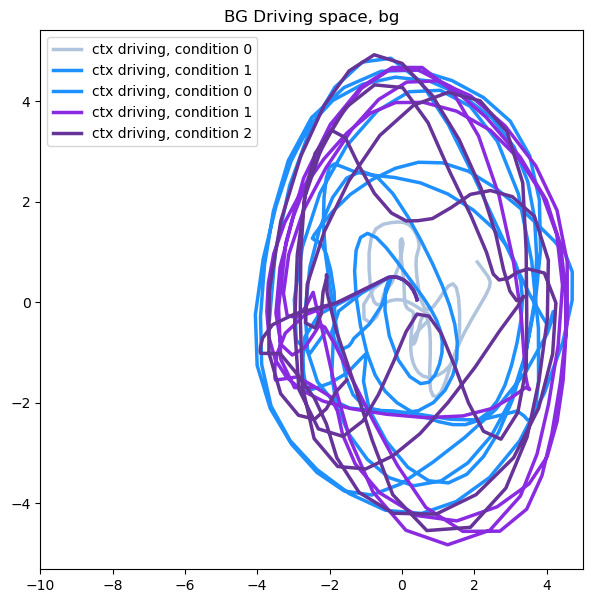

In [183]:
# reshape rates to be CT x N
ratesForPCA_ctxDriving = rates_bg_2[:,:,:2].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')
ratesForPCA_BGdriving = rates_bg_2[:,:,2:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')

# fit  pca model
pca = PCA(n_components = 10)
pca.fit(ratesForPCA_BGdriving);
proj_bgDriving = pca.transform(ratesForPCA_BGdriving).reshape((-1,3,10),order = 'F')
proj_ctxDriving = pca.transform(ratesForPCA_ctxDriving).reshape((-1,numConditions_MC,10),order = 'F')

# set up figure
fig = plt.figure(figsize = (7,7))
plt.title('BG Driving space, bg')

# plot projections from ctx driving condition
for i in np.arange(2):
    plt.plot(proj_ctxDriving[:,i,0].flatten(),proj_ctxDriving[:,i,1].flatten(),
            linewidth = proj_lw,color = bg_color2[i], label='ctx driving, condition ' + str(i));

# plot projection from bg driving condition
for i in np.arange(3):
    plt.plot(proj_bgDriving[:,i,0].flatten(),proj_bgDriving[:,i,1].flatten(),
            linewidth = proj_lw,color = bg_color2[i+1], label='ctx driving, condition ' + str(i));

plt.legend();
plt.xlim([-10,5]);
plt.savefig(figPath + 'bgDrivingSpace_bg.pdf');


### calculate alignment index between cortically-driven and bg-driven conditions
    - the alignment index measures the overlap between two k-dimensional spaces.
    - an alignement of 0 means the 2 spaces are orthogonal, and an alignment of 1 means they're perfectly overlapped.

In [184]:
# define a function to return the alignment index, given two T (or CT) x N matrices
# note that we're defining the space with X1, then projecting in X2
def calculateAI(X1,X2,numDims):

    # calculate the covariance matrix of X2
    X2_center = X2 - np.mean(X2, axis=0)
    C2 = (X2_center.T @ X2_center) / (X2_center.shape[0]-1)

    # run pca on X1 and X2
    pca1 = sklearn.decomposition.PCA(n_components=numDims)
    pca1.fit(X1)

    pca2 = sklearn.decomposition.PCA(n_components=numDims)
    pca2.fit(X2)

    # grab the pcs from X1 (spits out a k x N matrix by default)
    W = pca1.components_.T

    # calculate the variance explained by the top 'nDims' PCs of X2
    totVar = sum(pca2.explained_variance_)

    # calculate alignment index
    AI = np.trace((W.T @ C2 @ W)) / totVar

    return AI


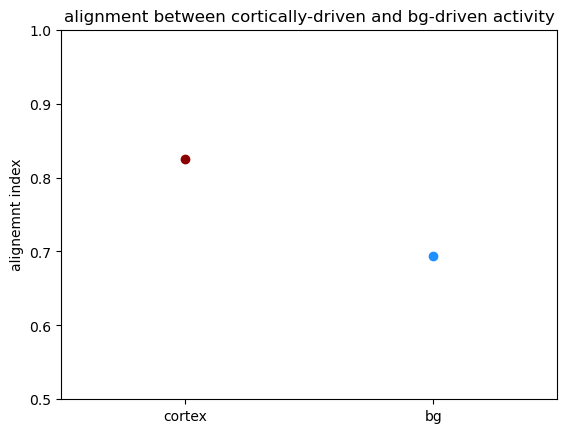

In [188]:
# calculate separate alignment indices for ctx and bg

# times to use for analysis
timesToUse = np.arange(30,120)

# ctx-driven rates
ctxDrive_ctx = rates_ctx_2[timesToUse,:,:2].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')
ctxDrive_bg = rates_bg_2[timesToUse,:,:2].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')

# bg-driven rates
bgDrive_ctx = rates_ctx_2[timesToUse,:,2:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')
bgDrive_bg = rates_bg_2[timesToUse,:,2:].transpose((0,2,1)).reshape((-1,numRecurrent),order = 'F')

# dimensions to use for AI calculation
numAIDims = 10

# calculate AI for cortex
cortexAI = calculateAI(ctxDrive_ctx,bgDrive_ctx,numAIDims)

# do the same for bg
bgAI = calculateAI(ctxDrive_bg,bgDrive_bg,numAIDims)

# plot results
plt.plot(0,cortexAI,'o',color='darkred')
plt.plot(1,bgAI,'o',color='dodgerblue')
plt.xticks(ticks=list(np.arange(2)), labels=['cortex','bg'])
plt.xlim([-0.5,1.5]);
plt.ylim([0.5,1]);
plt.ylabel('alignemnt index');
plt.title('alignment between cortically-driven and bg-driven activity');

plt.savefig(figPath + 'cortex_bg_alignmentIndices.pdf');


#### From the AI plots above, we can see that the 'bg-driven' and 'ctx-driven' spaces are highly overlapped in both nodes, but moreso (slightly) in cortex

#### So there isn't an obvious difference between ctx-driven and bg-driven activity in either BG activity or ctx activity.
    - can we distincguish between these two types of conditions by looking at the relationship between BG output (thalamus activity) and MC output?
    - it might be the case that in bg-driven conditions, BG output looks more like MC output (or these signals represent a larger fraction of overall BG output)

### Predict MC node output using BG-output
    - learn separate weights for each condition

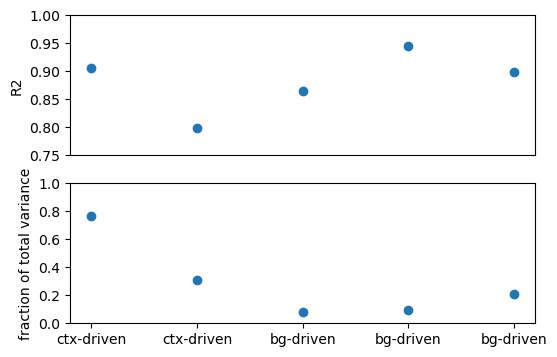

In [189]:
# learn weights to predict network output from BG output
# calculate R2 and fraction of variance for each decode

## import ridge regression function
from sklearn.linear_model import Ridge

# initialize a list to hold R2 and variance accounted for results
R2 = []
varAcc = []

# times to use for this analysis
timesToUse = np.arange(30,120)

# ridge parameter (probably unnecessary, given that we only have 3 thalamic units)
ridgeAlpha = 0.1


# cycle through conditions
for cc in range(5):

    # thalamic activity (BG output) for this condition (T x N)
    X = rates_thal_2[timesToUse,:,cc]

    # MC output for this condition
    Y = modelOutput_MC[cc,timesToUse,0].T;

    # define a regression object
    ridge = Ridge(alpha = ridgeAlpha)

    # regress
    ridge.fit(X,Y)

    # get our weights
    B = ridge.coef_

    # get R2 of fit
    R2.append(ridge.score(X,Y))

    # calculate fraction of variance this projection accounts for
    totVar = np.sum(np.var(X,axis=0))
    B_norm = B/np.linalg.norm(B)
    projVar = np.var( X @ B_norm.T)

    varAcc.append(projVar/totVar)

# plot everything
plt.figure(figsize=(6,4))

# plot fract. variance for each condition results
ax1 = plt.subplot(212)
plt.plot(varAcc,'o');
plt.ylabel('fraction of total variance')
plt.xticks(ticks=list(np.arange(5)), labels=['ctx-driven' if x < 2 else 'bg-driven' for x in np.arange(5)])
plt.ylim([0,1]);


# plot R2 results
ax2 = plt.subplot(211,sharex=ax1)
plt.plot(R2,'o');
plt.tick_params('x',labelbottom=False,bottom=False);
plt.ylabel('R2');
plt.ylim([0.75,1]);

plt.savefig(figPath + 'predictMCOutput_from_BGOutput.pdf');


#### Surprisingly, BG output predicts MC output *better* during ctx-driven conditions and these signals account for a greater fraction of overall BG output
